In [1]:
#Load Datasets
import requests
import pandas as pd
import numpy as np
import covalent_api as c
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
import datetime
from pandas import json_normalize

In [2]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import accuracy_score, r2_score, precision_score
from PIL import Image
from io import BytesIO
import pmdarima as pm

In [11]:
#Load Functions

def fetch_collection_hist(address):
    api_url = 'https://api.covalenthq.com'
    endpoint = f'/v1/1/nft_market/collection/{address}/'
    url = api_url + endpoint+'?key=ckey_c4376daa357b4dbdbf6d4ce3a65'
    r = requests.get(url)
    input_data = r.json()
    df = json_normalize(input_data['data']['items'])
    out = pd.DataFrame.from_records(df)
    return(out)



def fetch_collection_hist_test(address):
    api_url = 'https://api.covalenthq.com'
    endpoint = f'/v1/1/nft_market/collection/{address}/'
    url = api_url + endpoint+'?key=ckey_c4376daa357b4dbdbf6d4ce3a65'
    r = requests.get(url)
    input_data = r.json()
    return(input_data)

def fetch_token_id(address):
    api_url = 'https://api.covalenthq.com'
    endpoint = f'/v1/1/tokens/{address}/nft_token_ids/'
    url = api_url + endpoint
    r = requests.get(url, auth=('ckey_c4376daa357b4dbdbf6d4ce3a65', ''))
    input_data = r.json()
    return(input_data)

def fetch_token_tx(address, token_id):
    api_url = 'https://api.covalenthq.com'
    endpoint = f'/v1/1/tokens/{address}/nft_transactions/{token_id}/'
    url = api_url + endpoint
    r = requests.get(url, auth=('ckey_c4376daa357b4dbdbf6d4ce3a65',''))
    input_data = r.json()
    return(input_data)

def fetch_token_meta(address, token_id):
    api_url = 'https://api.covalenthq.com'
    endpoint = f'/v1/1/tokens/{address}/nft_metadata/{token_id}/'
    url = api_url + endpoint+'?key=ckey_c4376daa357b4dbdbf6d4ce3a65'
    r = requests.get(url, auth=('ckey_c4376daa357b4dbdbf6d4ce3a65',''))
    input_data = r.json()
    input_data = input_data['data']['items'][0]['nft_data']
    out = pd.DataFrame.from_records(input_data)
    out_2 = pd.DataFrame.from_records(out['external_data'])
    out_table = pd.DataFrame({'token_id': out['token_id']
                              ,'token_balance': out['token_balance']
                              ,'image_url': out_2['image']
                              ,'traits': out_2['attributes']})
    
    trait = pd.DataFrame.from_records(out_table['traits'][0])
    trait.loc[:,'token_id'] = out_table['token_id']
    trait['token_id'] = out_table['token_id'].tolist() * len(trait)
    trait['image_url'] = out_table['image_url'].tolist() * len(trait)            
    return(trait)

def stationary_test(x):
    out = adfuller(x.dropna())
    print('ADF Statistic: %f' % out[0])
    print('p-value: %f' % out[1])
    if out[1] <= 0.05:
        print('Time-series is stationary at 5% significance level.')
    else:
        print('Time-series is non-stationary at 5% significance level. Find the order of difference!')
        

# Accuracy metrics
def accuracy(y_hat, y):
    mape = np.mean(np.abs(y_hat - y)/np.abs(y))     
    rmse = np.mean((y_hat - y)**2)**0.5
    corr = np.corrcoef(y_hat, y)[0,1]   

    return({'Mean absolute percentage error':mape
            , 'Root mean squared error':rmse
            , 'corr':corr})    





In [4]:
nft_address ='0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d'

In [5]:
## Read in floor price

data = fetch_collection_hist(nft_address)

In [6]:
data['opening_date'] = pd.to_datetime(data['opening_date'])
data = data.sort_values(by='opening_date', ascending=True)
data.set_index('opening_date', inplace=True)

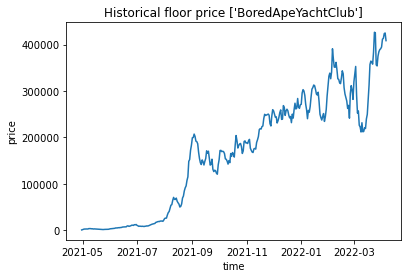

In [7]:
name = np.unique(data['collection_name']).tolist()
plt.plot( data["floor_price_quote_7d"])
plt.title("Historical floor price "+str(name))
plt.xlabel("time")
plt.ylabel("price")
plt.show()

0             The Eyes is: Eyepatch
1         The Background is: Orange
2        The Clothes is: Space Suit
3    The Hat is: Vietnam Era Helmet
4                 The Fur is: Brown
5          The Mouth is: Small Grin
dtype: object


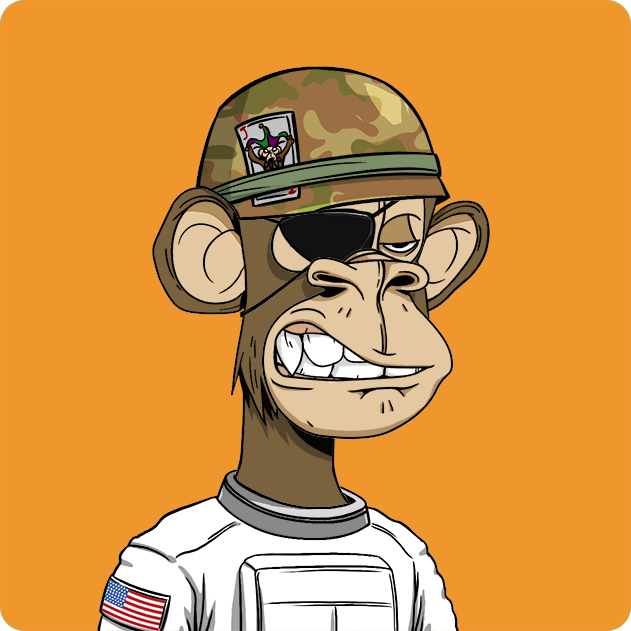

In [12]:
## Display the NFT & its traits
token_meta = fetch_token_meta(nft_address, '1071')
print("The "+token_meta["trait_type"]+" is: "+token_meta["value"])
url = token_meta['image_url'][0]
response = requests.get(url)
Image.open(BytesIO(response.content))


C:\Users\Oluwasogo\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\Users\Oluwasogo\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\Users\Oluwasogo\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


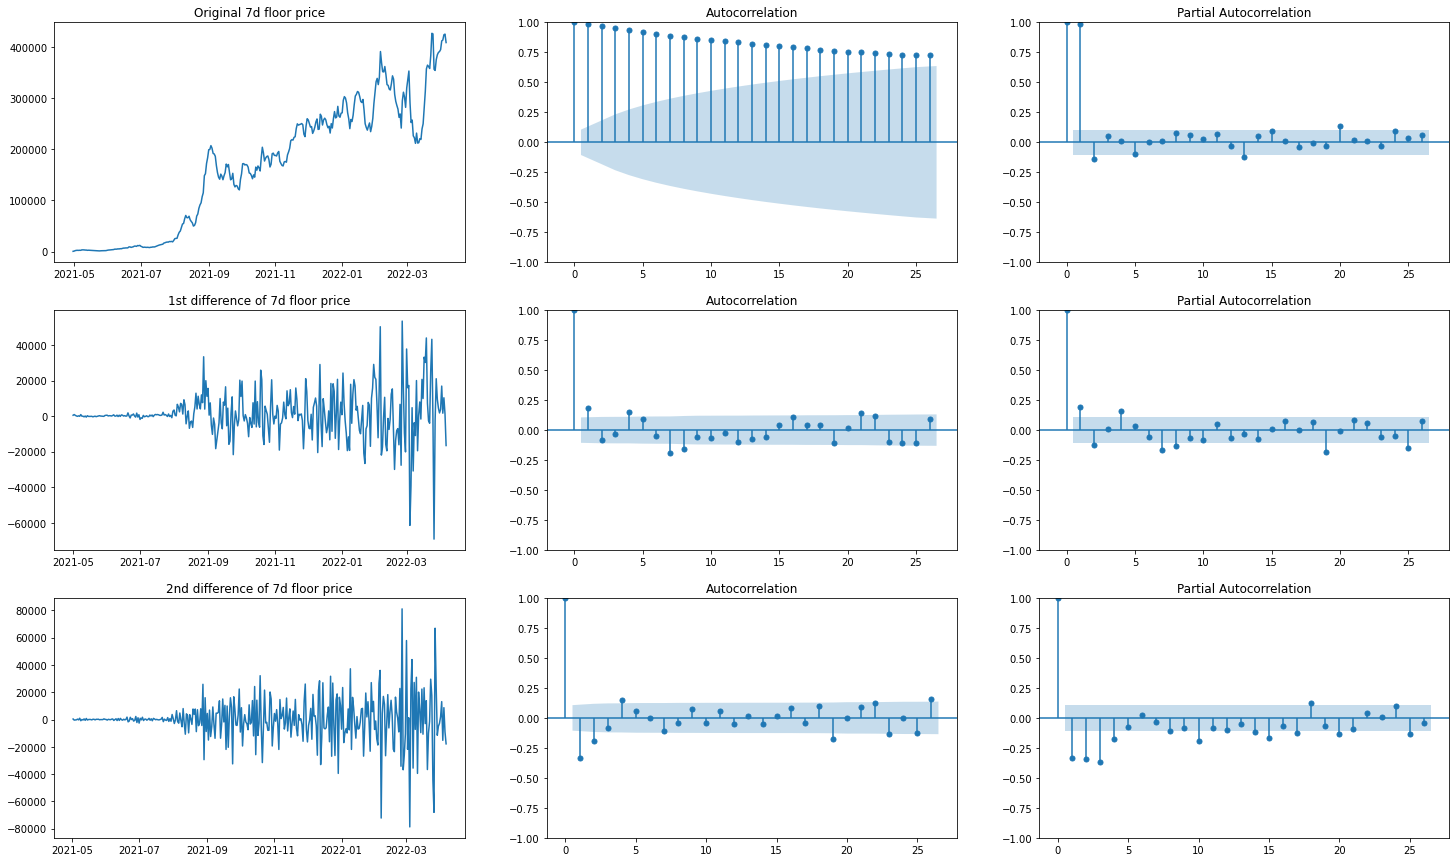

In [16]:
## Original floor price
fig, axes = plt.subplots(3, 3, sharex=False, figsize=(25,15))
diff0 = data['floor_price_quote_7d']
axes[0,0].plot(diff0); axes[0, 0].set_title('Original 7d floor price')
plot_acf(diff0.dropna(), ax=axes[0, 1])
axes[0,1].axis(xmin=-2, xmax=28)
plot_pacf(diff0.dropna(), ax=axes[0, 2])
axes[0,2].axis(xmin=-2, xmax=28)

## 1st diff
diff1 = data['floor_price_quote_7d'].diff()
axes[1,0].plot(diff1); axes[1, 0].set_title('1st difference of 7d floor price')
plot_acf(diff1.dropna(), ax=axes[1, 1])
axes[1,1].axis(xmin=-2, xmax=28)
plot_pacf(diff1.dropna(), ax=axes[1, 2])
axes[1,2].axis(xmin=-2, xmax=28)

## 2nd diff
## lag goes too far negative => over-differenced!
diff2 = data['floor_price_quote_7d'].diff().diff()
axes[2,0].plot(diff2); axes[2, 0].set_title('2nd difference of 7d floor price')
plot_acf(diff2.dropna(), ax=axes[2, 1])
plot_pacf(diff2.dropna(), ax=axes[2, 2])
plt.show()


In [17]:
## Stationarity Tests
stationary_test(diff0) ## non-stationary
stationary_test(diff1) ## stationary
stationary_test(diff2)


ADF Statistic: -0.388872
p-value: 0.911940
Time-series is non-stationary at 5% significance level. Find the order of difference!
ADF Statistic: -7.845918
p-value: 0.000000
Time-series is stationary at 5% significance level.
ADF Statistic: -6.891005
p-value: 0.000000
Time-series is stationary at 5% significance level.


In [18]:
##Training testing split##

train_size = round(len(data)*0.8)

train = data.floor_price_quote_7d[:train_size]
test = data.floor_price_quote_7d[train_size:]

In [19]:
##Finding optimal parameters##

model = pm.auto_arima(train, start_p=1, start_q=1, 
                     test = 'adf',   # use adftest to find optimal 'd'#
                     max_p=5, max_q=5,
                     # m=1,
                     d=None,
                     seasonal=False,
                     trace=True,
                     suppress_warnings=True,
                     stepwise=True,
                     random_state=123)


print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5729.675, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5735.080, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5728.820, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5728.163, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5735.909, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5729.880, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5731.750, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5728.210, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.584 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  274
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -2861.081
Date:                Wed, 07 Sep 2022   AIC                           5728.163
Time:                        15:39:5

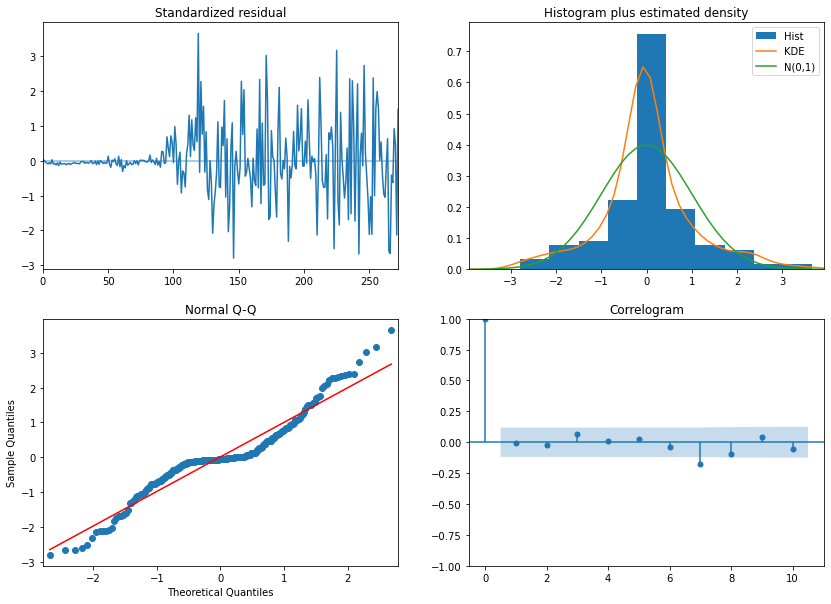

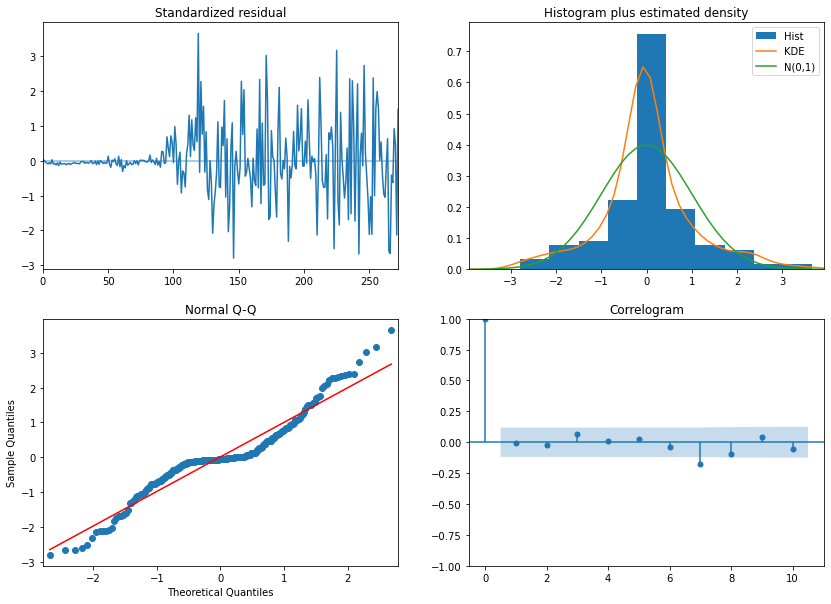

In [20]:
## check residuals
model.plot_diagnostics(figsize=(14,10))

In [21]:
## Prediction ##

pred, ci = model.predict(n_periods = len(test), return_conf_int=True)
idx = np.arange(len(train), len(train) + len(test))


In [22]:
test_pred = pd.Series(pred, index = idx)
lb = pd.Series(ci[:, 0], index = idx)
ub = pd.Series(ci[:, 1], index = idx)

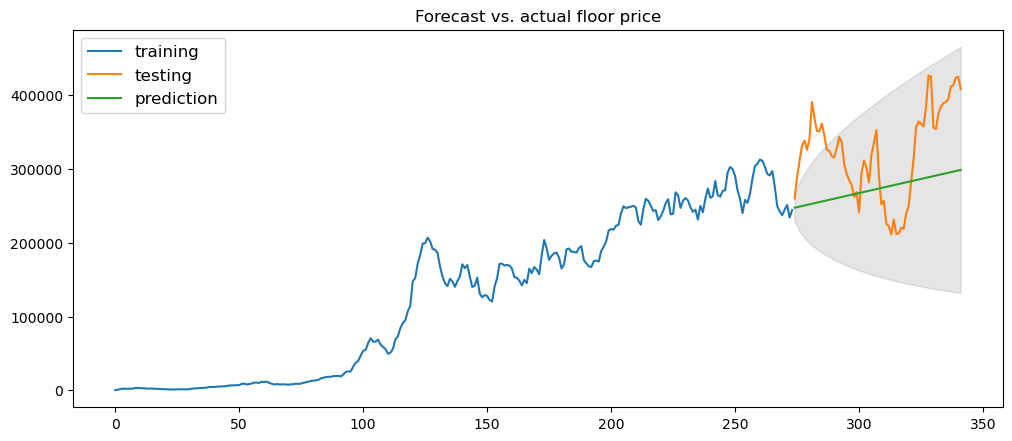

In [23]:
# Plot
plot_train = train.reset_index()
plot_test = pd.DataFrame(test).set_index(idx)
plot_pred = pd.DataFrame(test_pred).set_index(idx)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(plot_train.floor_price_quote_7d, label = "training")
plt.plot(plot_test.floor_price_quote_7d, label = "testing")
plt.plot(plot_pred, label = "prediction")
plt.fill_between(lb.index, lb, ub, color='k', alpha = 0.1)
plt.legend(loc='upper left', fontsize = 12)
plt.title("Forecast vs. actual floor price")
plt.show()


In [24]:
## Performance metrics
actual = pd.DataFrame(test).reset_index()
actual.columns = ['date','actual']

predict = pd.DataFrame(test_pred).reset_index()
predict.columns = ['date','predict']
accuracy(predict['predict'], actual['actual'])


{'Mean absolute percentage error': 0.19894706077108834,
 'Root mean squared error': 74919.8934665506,
 'corr': 0.2957063761541235}

In [25]:
print(data)

              chain_id    collection_name  \
opening_date                                
2021-04-30           1  BoredApeYachtClub   
2021-05-01           1  BoredApeYachtClub   
2021-05-02           1  BoredApeYachtClub   
2021-05-03           1  BoredApeYachtClub   
2021-05-04           1  BoredApeYachtClub   
...                ...                ...   
2022-04-02           1  BoredApeYachtClub   
2022-04-03           1  BoredApeYachtClub   
2022-04-04           1  BoredApeYachtClub   
2022-04-05           1  BoredApeYachtClub   
2022-04-06           1  BoredApeYachtClub   

                                      collection_address  \
opening_date                                               
2021-04-30    0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d   
2021-05-01    0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d   
2021-05-02    0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d   
2021-05-03    0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d   
2021-05-04    0xbc4ca0eda7647a8ab7c2061c2e118a18a936f1